# Customer Churn Prediction Analysis

## Project Overview
This notebook implements a comprehensive customer churn prediction model using deep learning techniques. The analysis follows a structured approach:

1. **EDA Phase** - Exploratory Data Analysis to understand the dataset
2. **Data Loading & Exploration** - Load and examine the e-commerce customer dataset
3. **Feature Engineering** - Create meaningful customer-level features
4. **Model Development** - Build and train a deep neural network
5. **Evaluation & Insights** - Analyze model performance and provide business insights

## Business Context
Customer churn prediction is critical for e-commerce businesses to:
- Identify at-risk customers early
- Implement targeted retention strategies
- Optimize customer lifetime value
- Reduce customer acquisition costs

## Success Metrics
- **Primary**: ROC-AUC Score (>0.70 considered good, >0.85 excellent)
- **Secondary**: Precision, Recall, F1-Score for business impact
- **Business**: Actionable insights for customer retention

## 1. Import Required Libraries

In [52]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                             roc_curve, balanced_accuracy_score, precision_score, recall_score,
                             precision_recall_curve, average_precision_score)

# Date/time processing
from datetime import datetime, timedelta

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Pandas version: {pd.__version__}")

✅ Libraries imported successfully
✅ TensorFlow version: 2.20.0
✅ NumPy version: 2.2.5
✅ Pandas version: 2.3.3


## 2. EDA Phase - Exploratory Data Analysis

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from datetime import datetime

# --- Configuration ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)

# Output Directory
OUTPUT_DIR = "EDA_Professional_Report/eda-before"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

class AdvancedEDA:
    def __init__(self, filepath, target_col=None):
        self.filepath = filepath
        self.target_col = target_col
        self.df = None
        self.numeric_cols = []
        self.categorical_cols = []
        self.date_cols = []
        self.report_data = [] # Stores text summary for report

    def log(self, message):
        """Logs to console and stores for report."""
        timestamp = datetime.now().strftime("%H:%M:%S")
        print(f"[{timestamp}] {message}")
        self.report_data.append(f"<li><b>{timestamp}:</b> {message}</li>")

    def load_and_preprocess(self):
        """Loads data, detects types, and handles basic cleaning."""
        self.log(f"Loading data from {self.filepath}...")
        self.df = pd.read_csv(self.filepath)
        self.log(f"Data Loaded. Shape: {self.df.shape}")

        # Date Parsing
        for col in self.df.columns:
            if 'date' in col.lower() or 'time' in col.lower():
                try:
                    self.df[col] = pd.to_datetime(self.df[col])
                    self.date_cols.append(col)
                    self.log(f"Converted '{col}' to datetime.")
                except:
                    pass

        # Identify Columns
        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()
       
        # Basic Cleaning
        duplicates = self.df.duplicated().sum()
        self.log(f"Removed {duplicates} duplicate rows.")
        self.df.drop_duplicates(inplace=True)
        
        # Handle missing values
        missing_data = self.df.isnull().sum()
        missing_percent = 100 * missing_data / len(self.df)
        missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percent})
        missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False)
        
        if not missing_df.empty:
            self.log(f"Missing values detected: {len(missing_df)} columns affected")
            for col, row in missing_df.iterrows():
                self.log(f"  - {col}: {row['Missing Count']} ({row['Percentage']:.2f}%)")
        else:
            self.log("No missing values detected.")

    def numeric_feature_analysis(self):
        """Analyze numeric features with statistics, correlations, and visualizations."""
        self.log("Running Numeric Feature Analysis...")
        
        if not self.numeric_cols:
            self.log("No numeric columns found.")
            return
            
        # Basic statistics
        stats_df = self.df[self.numeric_cols].describe()
        stats_df.to_csv(f"{OUTPUT_DIR}/numeric_stats.csv")
        self.log("Saved numeric statistics to 'numeric_stats.csv'")
        
        # Additional statistics: skewness and kurtosis
        additional_stats = pd.DataFrame({
            'skewness': [self.df[col].skew() for col in self.numeric_cols],
            'kurtosis': [self.df[col].kurtosis() for col in self.numeric_cols]
        }, index=self.numeric_cols)
        additional_stats.to_csv(f"{OUTPUT_DIR}/additional_stats.csv")
        self.log("Saved skewness and kurtosis to 'additional_stats.csv'")
        
        # Correlation matrix
        corr_matrix = self.df[self.numeric_cols].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/correlation_matrix.png")
        plt.close()
        
        # Correlation with target variable
        if self.target_col and self.target_col in self.numeric_cols:
            target_corr = corr_matrix[self.target_col].drop(self.target_col).sort_values(key=abs, ascending=False)
            plt.figure(figsize=(10, 6))
            sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
            plt.title(f'Correlation with {self.target_col}')
            plt.xlabel('Correlation Coefficient')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/target_correlation.png")
            plt.close()
            
        # PCA for dimensionality reduction
        if len(self.numeric_cols) > 1:
            # Prepare data for PCA (scale first)
            features = self.numeric_cols.copy()
            if self.target_col in features:
                features.remove(self.target_col)
            
            if len(features) > 1:
                scaler = StandardScaler()
                scaled_data = scaler.fit_transform(self.df[features].dropna())
                
                pca = PCA(n_components=2)
                pca_components = pca.fit_transform(scaled_data)
                
                plt.figure(figsize=(10, 8))
                plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.6)
                plt.title(f'PCA: First Two Components\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}')
                plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
                plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
                plt.tight_layout()
                plt.savefig(f"{OUTPUT_DIR}/pca_visualization.png")
                plt.close()

    def advanced_outlier_detection(self):
        """Detects outliers using IQR and Z-Score."""
        self.log("Running Advanced Outlier Detection...")
       
        outlier_summary = []
       
        for col in self.numeric_cols:
            if self.df[col].nunique() < 10: continue # Skip discrete/low-cardinality
           
            # IQR Method
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            iqr_outliers = ((self.df[col] < (Q1 - 1.5 * IQR)) | (self.df[col] > (Q3 + 1.5 * IQR))).sum()
           
            # Z-Score Method
            z_scores = np.abs(stats.zscore(self.df[col].dropna()))
            z_outliers = (z_scores > 3).sum()
           
            outlier_summary.append({
                'Feature': col,
                'IQR_Outliers': iqr_outliers,
                'Z_Score_Outliers': z_outliers,
                'Skewness': self.df[col].skew()
            })
           
            # Visual check for features with high outliers
            if z_outliers > 0 or iqr_outliers > 0:
                fig, ax = plt.subplots(1, 2, figsize=(14, 5))
                sns.histplot(self.df[col], kde=True, ax=ax[0], color='teal')
                ax[0].set_title(f'Distribution: {col}')
                sns.boxplot(x=self.df[col], ax=ax[1], color='salmon')
                ax[1].set_title(f'Boxplot: {col}')
                plt.tight_layout()
                plt.savefig(f"{OUTPUT_DIR}/outliers_{col}.png")
                plt.close()

        summary_df = pd.DataFrame(outlier_summary)
        summary_df.to_csv(f"{OUTPUT_DIR}/outlier_report.csv", index=False)
        self.log("Outlier detection complete. Saved 'outlier_report.csv'.")

    def categorical_feature_analysis(self):
        """Analyze categorical features."""
        self.log("Running Categorical Feature Analysis...")
        
        if not self.categorical_cols:
            self.log("No categorical columns found.")
            return
            
        for col in self.categorical_cols:
            unique_count = self.df[col].nunique()
            self.log(f"Column '{col}' has {unique_count} unique values")
            
            # Skip high cardinality columns
            if unique_count > 20:
                self.log(f"  Skipping '{col}' due to high cardinality ({unique_count} unique values)")
                continue
            
            # Plot top categories
            top_categories = self.df[col].value_counts().head(10)
            plt.figure(figsize=(10, 6))
            sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
            plt.title(f'Top Categories in {col}')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/cat_dist_{col}.png")
            plt.close()
            
            # Analyze relationship with target
            if self.target_col and self.target_col in self.df.columns:
                # Cross-tabulation
                crosstab = pd.crosstab(self.df[col], self.df[self.target_col], normalize='index') * 100
                crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
                plt.title(f'{self.target_col} Rate by {col}')
                plt.xlabel(col)
                plt.ylabel(f'{self.target_col} Rate (%)')
                plt.legend(title=self.target_col, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.savefig(f"{OUTPUT_DIR}/cat_target_{col}.png")
                plt.close()
                
                # Calculate target rates per category
                target_rates = self.df.groupby(col)[self.target_col].agg(['mean', 'count']).reset_index()
                target_rates.columns = [col, f'{self.target_col}_Rate', 'Count']
                target_rates = target_rates.sort_values(f'{self.target_col}_Rate', ascending=False)
                target_rates.to_csv(f"{OUTPUT_DIR}/target_rates_{col}.csv", index=False)

    def analyze_target(self):
        """Deep dive into target variable relationships."""
        if not self.target_col or self.target_col not in self.df.columns:
            self.log("Target column not specified or not found.")
            return
           
        self.log(f"Analyzing Target: {self.target_col}")
       
        # Numeric vs Target
        for col in self.numeric_cols:
            if col == 'Cluster' or col == self.target_col: continue
           
            plt.figure(figsize=(12, 6))
            # Boxen plot is better for large data than standard boxplot or violin
            sns.boxenplot(x=self.target_col, y=col, data=self.df, palette='coolwarm')
            plt.title(f'{col} vs {self.target_col}')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/target_rel_{col}.png")
            plt.close()
           
        # Categorical vs Target
        for col in self.categorical_cols:
            if self.df[col].nunique() > 15: continue
           
            plt.figure(figsize=(10, 6))
            # Normalized Stacked Bar
            ct = pd.crosstab(self.df[col], self.df[self.target_col], normalize='index')
            ct.plot(kind='barh', stacked=True, colormap='coolwarm', edgecolor='black')
            plt.title(f'{self.target_col} Ratio by {col}')
            plt.xlabel('Proportion')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/target_rel_{col}.png")
            plt.close()
            
        # Calculate mutual information for feature importance
        if self.target_col in self.numeric_cols:
            features = [col for col in self.numeric_cols if col != self.target_col]
            if features:
                X = self.df[features].dropna()
                y = self.df[self.target_col].loc[X.index]
                
                mi_scores = mutual_info_regression(X, y)
                mi_df = pd.DataFrame({'Feature': features, 'MI_Score': mi_scores})
                mi_df = mi_df.sort_values('MI_Score', ascending=False)
                
                plt.figure(figsize=(10, 6))
                sns.barplot(data=mi_df.head(10), x='MI_Score', y='Feature', palette='viridis')
                plt.title('Top 10 Features by Mutual Information Score')
                plt.tight_layout()
                plt.savefig(f"{OUTPUT_DIR}/mutual_info.png")
                plt.close()
                
                mi_df.to_csv(f"{OUTPUT_DIR}/mutual_info_scores.csv", index=False)
                self.log("Calculated mutual information scores for feature importance.")

    def time_series_trends(self):
        """Analyzes trends over time."""
        if not self.date_cols:
            self.log("No date columns found for Time Series Analysis.")
            return
           
        date_col = self.date_cols[0] # Use the first detected date column
        self.log(f"Analyzing Time Series using '{date_col}'...")
       
        # Set index
        ts_df = self.df.set_index(date_col).sort_index()
       
        # Resample logic (Monthly)
        numeric_target = self.df.select_dtypes(include=[np.number]).columns[0] # Default to first numeric
        if 'Total Purchase Amount' in self.df.columns: numeric_target = 'Total Purchase Amount'
       
        monthly = ts_df[numeric_target].resample('M').sum()
       
        plt.figure(figsize=(14, 6))
        monthly.plot(marker='o', linestyle='-', color='purple')
        plt.title(f'Monthly Trend: {numeric_target}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/time_series_trend.png")
        plt.close()
       
        # Seasonality (Day of Week)
        self.df['DayOfWeek'] = self.df[date_col].dt.day_name()
        order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
       
        plt.figure(figsize=(10, 6))
        sns.barplot(x='DayOfWeek', y=numeric_target, data=self.df, order=order, ci=None, palette='mako')
        plt.title(f'{numeric_target} by Day of Week')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/time_series_seasonality.png")
        plt.close()
        
        # Monthly seasonality
        self.df['Month'] = self.df[date_col].dt.month_name()
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Month', y=numeric_target, data=self.df, order=month_order, ci=None, palette='viridis')
        plt.title(f'{numeric_target} by Month')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/time_series_monthly.png")
        plt.close()

    def cluster_analysis(self, n_clusters=4):
        """Performs KMeans clustering to segment data."""
        self.log(f"Running Clustering (KMeans, k={n_clusters})...")
       
        # Prepare Data: Select numeric, dropna, scale
        features = self.numeric_cols.copy()
        if self.target_col in features: features.remove(self.target_col)
       
        # Handle missing for clustering
        cluster_df = self.df[features].dropna()
        if len(cluster_df) < 100:
            self.log("Not enough data for clustering.")
            return

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cluster_df)
       
        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(scaled_data)
       
        # Add to original DF (using index alignment)
        self.df.loc[cluster_df.index, 'Cluster'] = clusters
       
        # Visualize with PCA
        pca = PCA(n_components=2)
        pca_components = pca.fit_transform(scaled_data)
       
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=clusters, palette='viridis', alpha=0.6)
        plt.title(f'Customer Segments (PCA Projection)\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/clustering_pca.png")
        plt.close()
       
        # Cluster Profiles
        profile = self.df.groupby('Cluster')[features].mean()
        profile.to_csv(f"{OUTPUT_DIR}/cluster_profiles.csv")
        self.log("Clustering complete. Saved PCA plot and profiles.")

    def generate_html_report(self):
        """Compiles all findings into a single HTML file."""
        self.log("Generating HTML Report...")
       
        images = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]
        images.sort()
        
        # Read CSV files to include in the report
        csv_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.csv')]
        csv_tables = {}
        for csv_file in csv_files:
            try:
                df = pd.read_csv(f"{OUTPUT_DIR}/{csv_file}")
                # Limit the number of rows displayed for large tables
                if len(df) > 20:
                    display_df = pd.concat([df.head(10), pd.DataFrame(['...'], columns=['...']) * len(df.columns), df.tail(10)])
                else:
                    display_df = df
                csv_tables[csv_file] = display_df.to_html(classes='data-table', table_id=csv_file.replace('.csv', '_table'), escape=False)
            except Exception as e:
                self.log(f"Could not read CSV file {csv_file}: {str(e)}")
       
        html_content = f"""
        <html>
        <head>
            <title>Professional EDA Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f4f4f9; }}
                h1 {{ color: #2c3e50; }}
                h2, h3 {{ color: #34495e; }}
                .container {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(500px, 1fr)); gap: 20px; }}
                .card {{ background: white; padding: 15px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }}
                img {{ max-width: 100%; height: auto; border-radius: 4px; }}
                ul {{ background: #fff; padding: 20px; border-radius: 8px; list-style-type: none; }}
                li {{ padding: 8px 0; border-bottom: 1px solid #eee; }}
                .data-table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin: 10px 0;
                    font-size: 0.9em;
                    font-family: sans-serif;
                    min-width: 400px;
                    border-radius: 5px 5px 0 0;
                    overflow: hidden;
                    box-shadow: 0 0 20px rgba(0, 0, 0, 0.15);
                }}
                .data-table thead tr {{
                    background-color: #009879;
                    color: #ffffff;
                    text-align: left;
                }}
                .data-table th,
                .data-table td {{
                    padding: 12px 15px;
                    text-align: center;
                }}
                .data-table tbody tr {{
                    border-bottom: 1px solid #dddddd;
                }}
                .data-table tbody tr:nth-of-type(even) {{
                    background-color: #f3f3f3;
                }}
                .data-table tbody tr:last-of-type {{
                    border-bottom: 2px solid #009879;
                }}
                .data-table tbody tr:hover {{
                    background-color: #f5f5f5;
                }}
            </style>
        </head>
        <body>
            <h1>Automated EDA Report</h1>
            
            <h2>Processing Log</h2>
            <div class="card">
                <ul>
                    {{''.join(self.report_data)}}
                </ul>
            </div>
            
            <h2>Visualizations</h2>
            <div class="container">
        """
       
        for img in images:
            html_content += f"""
                <div class="card">
                    <h4>{img}</h4>
                    <img src="{img}" alt="{img}">
                </div>
            """
           
        html_content += """
            </div>
            
            <h2>Data Tables</h2>
        """
        
        for csv_file, table_html in csv_tables.items():
            html_content += f"""
            <div class="card">
                <h4>{csv_file}</h4>
                {table_html}
            </div>
            """
           
        html_content += """
        </body>
        </html>
        """
       
        with open(f"{OUTPUT_DIR}/EDA_Summary_Report.html", "w") as f:
            f.write(html_content)
       
        print(f"\n[SUCCESS] Report generated at: {OUTPUT_DIR}/EDA_Summary_Report.html")

# --- Execution ---
FILE_PATH = 'data/ecommerce_customer_data_large.csv'

if os.path.exists(FILE_PATH):
    # Initialize
    eda = AdvancedEDA(FILE_PATH, target_col='Churn')
   
    # Pipeline
    eda.load_and_preprocess()
    eda.numeric_feature_analysis()
    eda.advanced_outlier_detection()
    eda.categorical_feature_analysis()
    eda.cluster_analysis(n_clusters=4) # Automatic customer segmentation
    eda.analyze_target()
    eda.time_series_trends()
    eda.generate_html_report()
   
else:
    print(f"File '{FILE_PATH}' not found. Please upload the dataset.")

# Display the EDA report location
print(f"\nEDA Report saved at: {OUTPUT_DIR}/EDA_Summary_Report.html")

[00:37:37] Loading data from data/ecommerce_customer_data_large.csv...
[00:37:37] Data Loaded. Shape: (250000, 13)
[00:37:37] Converted 'Purchase Date' to datetime.
[00:37:37] Removed 0 duplicate rows.
[00:37:37] Missing values detected: 1 columns affected
[00:37:37]   - Returns: 47382.0 (18.95%)
[00:37:37] Running Numeric Feature Analysis...
[00:37:37] Saved numeric statistics to 'numeric_stats.csv'
[00:37:38] Saved skewness and kurtosis to 'additional_stats.csv'
[00:37:39] Running Advanced Outlier Detection...
[00:37:39] Outlier detection complete. Saved 'outlier_report.csv'.
[00:37:39] Running Categorical Feature Analysis...
[00:37:39] Column 'Product Category' has 4 unique values
[00:37:40] Column 'Payment Method' has 3 unique values
[00:37:40] Column 'Customer Name' has 39878 unique values
[00:37:40]   Skipping 'Customer Name' due to high cardinality (39878 unique values)
[00:37:40] Column 'Gender' has 2 unique values
[00:37:40] Running Clustering (KMeans, k=4)...
[00:37:54] Clust

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## 3. Data Loading and Initial Exploration

In [54]:
# Load the e-commerce customer dataset
print("🔍 Loading e-commerce customer data...")

# Path to your dataset
file_path = 'data/ecommerce_customer_data_large.csv'

try:
    # Read the CSV file
    df = pd.read_csv(file_path)
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Display basic information about the dataset
    print(f"\n📈 Dataset Info:")
    print(f"   • Total records: {len(df):,}")
    print(f"   • Total features: {len(df.columns)}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Show first few rows
    print(f"\n📖 First 5 rows:")
    print(df.head())
    
    # Basic statistics
    print(f"\n📈 Basic Statistics:")
    print(df.describe())
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {file_path}")
    print(f"💡 Please ensure the file exists in the 'data' directory")
    raise

🔍 Loading e-commerce customer data...
✅ Dataset loaded successfully!
📊 Shape: (250000, 13)
📋 Columns: ['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']

📈 Dataset Info:
   • Total records: 250,000
   • Total features: 13
   • Memory usage: 85.90 MB

📖 First 5 rows:
   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        44605  2023-05-03 21:30:02             Home            177         1   
1        44605  2021-05-16 13:57:44      Electronics            174         3   
2        44605  2020-07-13 06:16:57            Books            413         1   
3        44605  2023-01-17 13:14:36      Electronics            396         3   
4        44605  2021-05-01 11:29:27            Books            259         4   

   Total Purchase Amount Payment Method  Customer Age  Returns Customer Name  \
0                   24

## 4. Feature Engineering & Data Preprocessing

In [55]:
print("="*80)
print("CUSTOMER-LEVEL CHURN PREDICTION: PROPER FEATURE ENGINEERING")
print("="*80)

# ============================================================================
# PART 1: PREPARE BASE DATA
# ============================================================================
print("\n📋 Step 1: Preparing base data...")

df_prepared = df.copy()

# Handle missing values
df_prepared['Returns'] = df_prepared['Returns'].fillna(0).astype(int)

# Convert Purchase Date to datetime
df_prepared['Purchase Date'] = pd.to_datetime(df_prepared['Purchase Date'])

# Keep Customer ID - WE NEED THIS!
# Rename for consistency

# Handle the duplicate Age columns properly
# The original data has both 'Customer Age' and 'Age' columns, we'll keep 'Customer Age' and drop the other Age column
df_prepared = df_prepared.drop(columns=['Age'])  # Drop the original 'Age' column first

df_prepared = df_prepared.rename(columns={
    'Customer Age': 'Age',
    'Customer ID': 'Customer_ID',
    'Customer Name': 'Customer_Name'
})

print(f"✅ Original dataset: {df_prepared.shape}")
print(f"✅ Date range: {df_prepared['Purchase Date'].min()} to {df_prepared['Purchase Date'].max()}")
print(f"✅ Unique customers: {df_prepared['Customer_ID'].nunique():,}")
print(f"✅ Total transactions: {len(df_prepared):,}")

# ============================================================================
# PART 2: AGGREGATE TO CUSTOMER LEVEL
# ============================================================================
print("\n" + "="*80)
print("📊 Step 2: Aggregating transactions to customer level...")
print("="*80)

# Define analysis date (latest date in dataset)
analysis_date = df_prepared['Purchase Date'].max()
print(f"\n📅 Analysis date: {analysis_date}")

# Calculate product category preferences per customer
category_pivot = df_prepared.pivot_table(
    index='Customer_ID',
    columns='Product Category',
    values='Total Purchase Amount',
    aggfunc='sum',
    fill_value=0
)
category_pivot.columns = [f'Spent_on_{col}' for col in category_pivot.columns]

# Calculate payment method preferences per customer
payment_pivot = df_prepared.pivot_table(
    index='Customer_ID',
    columns='Payment Method',
    values='Total Purchase Amount',
    aggfunc='count',
    fill_value=0
)
payment_pivot.columns = [f'Used_{col.replace(" ", "_")}' for col in payment_pivot.columns]

# Do aggregations separately to avoid the DataFrame.name error
print("   Aggregating purchase behavior...")
purchase_agg = df_prepared.groupby('Customer_ID').agg({
    'Total Purchase Amount': ['sum', 'mean', 'std', 'min', 'max', 'count'],
    'Quantity': ['sum', 'mean', 'std'],
    'Product Price': ['mean', 'std', 'min', 'max'],
    'Returns': ['sum', 'mean', 'max']
})
purchase_agg.columns = ['_'.join(col).strip() for col in purchase_agg.columns.values]

print("   Aggregating temporal features...")
temporal_agg = df_prepared.groupby('Customer_ID')['Purchase Date'].agg(['min', 'max', 'count'])
temporal_agg.columns = ['First_Purchase_Date', 'Last_Purchase_Date', 'Purchase_Count_Check']

print("   Aggregating demographics...")
# Fixed: Use .name attribute instead of .rename()
age_df = df_prepared.groupby('Customer_ID')['Age'].mean()
age_df.name = 'Age'

gender_df = df_prepared.groupby('Customer_ID')['Gender'].apply(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)
gender_df.name = 'Gender'

# Combine all aggregations
customer_features = purchase_agg.join(temporal_agg).join(age_df).join(gender_df).reset_index()

# Rename for clarity
customer_features = customer_features.rename(columns={
    'Total Purchase Amount_sum': 'Total_Lifetime_Value',
    'Total Purchase Amount_mean': 'Avg_Order_Value',
    'Total Purchase Amount_std': 'Order_Value_Volatility',
    'Total Purchase Amount_min': 'Min_Order_Value',
    'Total Purchase Amount_max': 'Max_Order_Value',
    'Total Purchase Amount_count': 'Total_Transactions',
    'Quantity_sum': 'Total_Items_Purchased',
    'Quantity_mean': 'Avg_Items_Per_Order',
    'Quantity_std': 'Items_Per_Order_Std',
    'Product Price_mean': 'Avg_Product_Price',
    'Product Price_std': 'Product_Price_Volatility',
    'Product Price_min': 'Min_Product_Price',
    'Product Price_max': 'Max_Product_Price',
    'Returns_sum': 'Total_Returns',
    'Returns_mean': 'Avg_Returns_Per_Order',
    'Returns_max': 'Max_Returns_Single_Order'
})

# Merge category and payment preferences
customer_features = customer_features.merge(category_pivot, on='Customer_ID', how='left')
customer_features = customer_features.merge(payment_pivot, on='Customer_ID', how='left')

print(f"\n✅ Customer-level dataset created: {customer_features.shape}")
print(f"✅ Features per customer: {customer_features.shape[1]}")

# ============================================================================
# PART 3: CREATE POWERFUL TEMPORAL FEATURES (KEY TO CHURN PREDICTION!)
# ============================================================================
print("\n" + "="*80)
print("🔥 Step 3: Creating temporal features (THE GAME CHANGERS!)...")
print("="*80)

# 1. RECENCY - Most important churn predictor!
customer_features['Days_Since_Last_Purchase'] = (
    analysis_date - customer_features['Last_Purchase_Date']
).dt.days

# 2. FREQUENCY - How often do they buy?
customer_features['Customer_Lifetime_Days'] = (
    customer_features['Last_Purchase_Date'] - customer_features['First_Purchase_Date']
).dt.days + 1  # Add 1 to avoid division by zero

customer_features['Purchases_Per_Month'] = (
    customer_features['Total_Transactions'] / (customer_features['Customer_Lifetime_Days'] / 30)
)

customer_features['Avg_Days_Between_Purchases'] = (
    customer_features['Customer_Lifetime_Days'] / 
    (customer_features['Total_Transactions'] + 1)
)

# 3. MONETARY - Spending patterns
customer_features['Spending_Per_Day'] = (
    customer_features['Total_Lifetime_Value'] / customer_features['Customer_Lifetime_Days']
)

# 4. TREND - Are they becoming more or less active? (VERY POWERFUL!)
def calculate_recent_vs_old_ratio(customer_id, recent_days=90):
    """Compare recent behavior vs historical behavior"""
    customer_data = df_prepared[df_prepared['Customer_ID'] == customer_id].copy()
    
    if len(customer_data) < 2:
        return 0  # Not enough data
    
    cutoff_date = analysis_date - pd.Timedelta(days=recent_days)
    
    recent = customer_data[customer_data['Purchase Date'] >= cutoff_date]
    old = customer_data[customer_data['Purchase Date'] < cutoff_date]
    
    if len(old) == 0:
        return 1  # New customer, recent activity only
    
    recent_purchases = len(recent)
    old_purchases = len(old)
    
    recent_days_active = (analysis_date - cutoff_date).days
    old_days_active = (cutoff_date - customer_data['Purchase Date'].min()).days
    
    if old_days_active == 0:
        return 1
    
    recent_rate = recent_purchases / recent_days_active
    old_rate = old_purchases / old_days_active
    
    if old_rate == 0:
        return 1
    
    return recent_rate / old_rate  # >1 = increasing activity, <1 = decreasing

print("\n   Calculating purchase trends (this may take a moment)...")
customer_features['Activity_Trend_90d'] = customer_features['Customer_ID'].apply(
    lambda x: calculate_recent_vs_old_ratio(x, recent_days=90)
)

# 5. ENGAGEMENT METRICS
customer_features['Return_Rate'] = (
    customer_features['Total_Returns'] / customer_features['Total_Items_Purchased']
).fillna(0)

customer_features['Order_Value_Consistency'] = (
    customer_features['Order_Value_Volatility'] / (customer_features['Avg_Order_Value'] + 1)
).fillna(0)

# 6. CUSTOMER LIFECYCLE STAGE
customer_features['Is_New_Customer'] = (customer_features['Customer_Lifetime_Days'] <= 30).astype(int)
customer_features['Is_VIP'] = (
    customer_features['Total_Lifetime_Value'] > customer_features['Total_Lifetime_Value'].quantile(0.9)
).astype(int)

# 7. RECENT ACTIVITY FLAGS (Last 30/60/90 days)
for days in [30, 60, 90]:
    cutoff = analysis_date - pd.Timedelta(days=days)
    recent_activity = df_prepared[df_prepared['Purchase Date'] >= cutoff].groupby('Customer_ID').agg({
        'Total Purchase Amount': ['sum', 'count']
    }).reset_index()
    recent_activity.columns = ['Customer_ID', f'Spending_Last_{days}d', f'Purchases_Last_{days}d']
    customer_features = customer_features.merge(recent_activity, on='Customer_ID', how='left')
    customer_features[f'Spending_Last_{days}d'] = customer_features[f'Spending_Last_{days}d'].fillna(0)
    customer_features[f'Purchases_Last_{days}d'] = customer_features[f'Purchases_Last_{days}d'].fillna(0)

print("✅ Temporal features created!")

# ============================================================================
# PART 4: DEFINE CHURN TARGET
# ============================================================================
print("\n" + "="*80)
print("🎯 Step 4: Defining churn target...")
print("="*80)

# Define churn threshold - adjust based on your business!
# Common values: 60, 90, 120, or 180 days
CHURN_THRESHOLD_DAYS = 90

customer_features['Churn'] = (
    customer_features['Days_Since_Last_Purchase'] > CHURN_THRESHOLD_DAYS
).astype(int)

churn_rate = customer_features['Churn'].mean()
churned_count = customer_features['Churn'].sum()
active_count = (1 - customer_features['Churn']).sum()

print(f"\n📊 Churn Definition: No purchase in last {CHURN_THRESHOLD_DAYS} days")
print(f"   Churn Rate: {churn_rate:.2%}")
print(f"   Churned Customers: {churned_count:,}")
print(f"   Active Customers: {active_count:,}")

if churn_rate < 0.05 or churn_rate > 0.95:
    print(f"\n⚠️  WARNING: Churn rate is extreme ({churn_rate:.2%})!")
    print(f"   Consider adjusting CHURN_THRESHOLD_DAYS")

# ============================================================================
# PART 5: PREPARE FINAL DATASET FOR MODELING
# ============================================================================
print("\n" + "="*80)
print("🎨 Step 5: Preparing final dataset...")
print("="*80)

# Encode categorical variables
customer_features['Gender'] = customer_features['Gender'].map({'Female': 1, 'Male': 0})

# 🛑 THE PREDICTIVE FIREWALL
# We exclude anything that "looks" into the 90-day churn window
exclude_cols = [
    'Customer_ID', 'First_Purchase_Date', 'Last_Purchase_Date', 
    'Days_Since_Last_Purchase', 'Purchase_Count_Check',
    'Purchases_Last_90d', 'Spending_Last_90d', 'Activity_Trend_90d',
    'Purchases_Last_60d', 'Spending_Last_60d',  # Also exclude 60-day window to be safe
    'Purchases_Last_30d', 'Spending_Last_30d'   # And 30-day window to be extra safe
]

if 'Customer_Name' in customer_features.columns:
    exclude_cols.append('Customer_Name')

feature_cols = [col for col in customer_features.columns 
                if col not in exclude_cols + ['Churn']]

# Create final modeling dataset
df_final = customer_features[feature_cols + ['Churn']].fillna(0)

print(f"\n✅ Final dataset shape: {df_final.shape}")
print(f"✅ Total features: {len(feature_cols)}")
print(f"✅ Churn rate: {df_final['Churn'].mean():.2%}")

# ============================================================================
# PART 6: FEATURE IMPORTANCE PREVIEW
# ============================================================================
print("\n" + "="*80)
print("🔍 Step 6: Quick feature correlation analysis...")
print("="*80)

# Calculate correlation with churn
correlations = df_final.corr()['Churn'].drop('Churn').sort_values(ascending=False)

print("\n Top 15 Features Most Correlated with Churn:")
print("-" * 60)
for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n📊 Top 15 Features Most Negatively Correlated (Retain Customers):")
print("-" * 60)
for i, (feature, corr) in enumerate(correlations.tail(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

# ============================================================================
# PART 7: SAVE AND SUMMARIZE
# ============================================================================
print("\n" + "="*80)
print("💾 Step 7: Saving datasets...")
print("="*80)

# Save the customer-level features (with IDs for reference)
customer_features_full = customer_features.copy()
print(f"\n✅ Saved: customer_features_full (with Customer_ID)")

print(f"✅ Saved: df_final (ready for modeling)")

print("\n" + "="*80)
print("🎉 FEATURE ENGINEERING COMPLETE!")
print("="*80)

print(f"""
📋 SUMMARY:
   • Original transactions: {len(df_prepared):,}
   • Unique customers: {customer_features.shape[0]:,}
   • Features per customer: {len(feature_cols)}
   • Churn threshold: {CHURN_THRESHOLD_DAYS} days
   • Churn rate: {churn_rate:.2%}

🔥 KEY FEATURES CREATED:
   ✓ Recency: Days_Since_Last_Purchase (MOST IMPORTANT!)
   ✓ Frequency: Purchases_Per_Month, Avg_Days_Between_Purchases
   ✓ Monetary: Total_Lifetime_Value, Avg_Order_Value
   ✓ Trend: Activity_Trend_90d (increasing/decreasing activity)
   ✓ Recent activity: Purchases_Last_30d/60d/90d
   ✓ Behavioral: Return_Rate, Order_Value_Consistency

🚀 NEXT STEPS:
   1. Use 'df_final' for modeling
   2. Expected AUC: 0.70 - 0.85+ (vs your previous 0.50!)
   3. Run XGBoost or Neural Network with these features
   4. Profit! 💰

💡 WHY THIS WILL WORK:
   Your previous approach: Transaction-level with no temporal patterns
   This approach: Customer-level with behavioral trends over time
   
   The difference? NIGHT AND DAY! 🌙☀️
""")

# Display sample of final data
print("\n📊 Sample of final modeling dataset:")
print(df_final.head(10))

print("\n" + "="*80)
print("Ready to train models with df_final!")
print("="*80)

CUSTOMER-LEVEL CHURN PREDICTION: PROPER FEATURE ENGINEERING

📋 Step 1: Preparing base data...
✅ Original dataset: (250000, 12)
✅ Date range: 2020-01-01 00:07:26 to 2023-09-13 18:42:49
✅ Unique customers: 49,661
✅ Total transactions: 250,000

📊 Step 2: Aggregating transactions to customer level...

📅 Analysis date: 2023-09-13 18:42:49
   Aggregating purchase behavior...
   Aggregating temporal features...
   Aggregating demographics...

✅ Customer-level dataset created: (49661, 29)
✅ Features per customer: 29

🔥 Step 3: Creating temporal features (THE GAME CHANGERS!)...

   Calculating purchase trends (this may take a moment)...
✅ Temporal features created!

🎯 Step 4: Defining churn target...

📊 Churn Definition: No purchase in last 90 days
   Churn Rate: 71.28%
   Churned Customers: 35,398
   Active Customers: 14,263

🎨 Step 5: Preparing final dataset...

✅ Final dataset shape: (49661, 34)
✅ Total features: 33
✅ Churn rate: 71.28%

🔍 Step 6: Quick feature correlation analysis...

 Top 

## 4. Deep Learning Model Development

In [56]:
print("="*80)
print("DEEP LEARNING FOR CUSTOMER-LEVEL CHURN PREDICTION")
print("="*80)

# ============================================================================
# PART 1: PREPARE DATA
# ============================================================================
print("\n📋 Preparing data...")

# Scale all features (they're all numeric after our feature engineering)
scaler = StandardScaler()
X_unscaled = df_final.drop(columns=['Churn']).values
y = df_final['Churn'].values

# Fit and transform
X = scaler.fit_transform(X_unscaled)

print(f"✅ Data shape: {X.shape}")
print(f"✅ Features: {X.shape[1]}")
print(f"✅ Samples: {X.shape[0]:,}")
print(f"✅ Churn rate: {y.mean():.2%}")

# Train/Val/Test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\n📊 Split sizes:")
print(f"   Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# ============================================================================
# PART 2: BUILD A SOPHISTICATED NEURAL NETWORK
# ============================================================================
print("\n" + "="*80)
print("🧠 BUILDING NEURAL NETWORK")
print("="*80)

# Calculate sample weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)

# Create sample weights
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 0] = class_weights_array[0]
sample_weights[y_train == 1] = class_weights_array[1]

print(f"\n⚖️ Class weights:")
print(f"   Class 0 (Active):  {class_weights_array[0]:.4f}")
print(f"   Class 1 (Churned): {class_weights_array[1]:.4f}")
print(f"   Ratio: {class_weights_array[1]/class_weights_array[0]:.2f}x more weight on churned customers")

# Clear any previous models
keras.backend.clear_session()

# Build a deep neural network optimized for customer churn
def create_model(input_dim, learning_rate=0.001):
    """
    Creates a sophisticated neural network with:
    - Multiple hidden layers
    - Batch normalization
    - Dropout for regularization
    - L2 regularization
    
    Args:
        input_dim (int): Number of input features
        learning_rate (float): Learning rate for the optimizer
        
    Returns:
        keras.Sequential: Configured neural network model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # First hidden layer - capture high-level patterns
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Second hidden layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Third hidden layer
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Fourth hidden layer
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Fifth hidden layer - fine-grained patterns
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with Adam optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Create model
model = create_model(X_train.shape[1], learning_rate=0.001)

print("\n🏗️ Neural Network Architecture:")
model.summary()

# ============================================================================
# PART 3: TRAIN WITH BEST PRACTICES
# ============================================================================
print("\n" + "="*80)
print("🚀 TRAINING NEURAL NETWORK")
print("="*80)

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

# Train the model
print("\n⚙️ Training configuration:")
print("   • Class weighting: Enabled")
print("   • Early stopping: 20 epochs patience")
print("   • Learning rate reduction: On plateau")
print("   • Max epochs: 150")
print("   • Batch size: 128")
print("\n" + "-"*80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=128,
    sample_weight=sample_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")
print(f"   Total epochs trained: {len(history.history['loss'])}")

DEEP LEARNING FOR CUSTOMER-LEVEL CHURN PREDICTION

📋 Preparing data...
✅ Data shape: (49661, 33)
✅ Features: 33
✅ Samples: 49,661
✅ Churn rate: 71.28%

📊 Split sizes:
   Training:   29,796 samples (60.0%)
   Validation: 9,932 samples (20.0%)
   Test:       9,933 samples (20.0%)

🧠 BUILDING NEURAL NETWORK

⚖️ Class weights:
   Class 0 (Active):  1.7410
   Class 1 (Churned): 0.7014
   Ratio: 0.40x more weight on churned customers

🏗️ Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,401 (212.50 KB)

 Trainable params: 53,441 (208.75 KB)

 Non-trainable params: 960 (3.75 KB)


🚀 TRAINING NEURAL NETWORK

⚙️ Training configuration:
   • Class weighting: Enabled
   • Early stopping: 20 epochs patience
   • Learning rate reduction: On plateau
   • Max epochs: 150
   • Batch size: 128

--------------------------------------------------------------------------------
Epoch 1/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6368 - auc: 0.6822 - loss: 1.0110 - precision: 0.8094 - recall: 0.6416 - val_accuracy: 0.7429 - val_auc: 0.7715 - val_loss: 0.8909 - val_precision: 0.8319 - val_recall: 0.8011 - learning_rate: 0.0010
Epoch 2/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7173 - auc: 0.7554 - loss: 0.8949 - precision: 0.8405 - recall: 0.7448 - val_accuracy: 0.7388 - val_auc: 0.7789 - val_loss: 0.8390 - val_precision: 0.8419 - val_recall: 0.7801 - learning_rate: 0.0010
Epoch 3/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7384 - auc: 0.7679 - loss: 0.8249 - precision: 0.8452 - recall: 0.7748 - val_accuracy: 0.7388 - val_auc: 0.77

## 5. Model Evaluation and Performance Analysis

In [57]:
# ============================================================================
# PART 4: EVALUATE PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("🎯 VALIDATION SET PERFORMANCE")
print("="*80)

# Get predictions
y_val_probs = model.predict(X_val, verbose=0).flatten()

# Calculate ROC-AUC
val_auc = roc_auc_score(y_val, y_val_probs)
print(f"\n🎯 Validation ROC-AUC: {val_auc:.4f}")

if val_auc < 0.55:
    print("\n⚠️ WARNING: AUC is still near 0.5 (random guessing)!")
    print("   The model is struggling to find patterns.")
elif val_auc < 0.70:
    print("\n⚠️ Moderate performance - room for improvement")
elif val_auc < 0.85:
    print("\n✅ Good performance! The model found meaningful patterns.")
else:
    print("\n🎉 Excellent performance! Strong predictive power!")

# Find optimal threshold using balanced accuracy
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred = (y_val_probs >= thresh).astype(int)
    accuracy = balanced_accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    results.append({
        'threshold': thresh,
        'balanced_accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

results_df = pd.DataFrame(results)
optimal_threshold = results_df.loc[results_df['balanced_accuracy'].idxmax(), 'threshold']
print(f"\n🎯 Optimal threshold: {optimal_threshold:.3f}")

# Make predictions with optimal threshold
y_val_pred = (y_val_probs >= optimal_threshold).astype(int)

print("\n" + "-"*80)
print("CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_val, y_val_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.4f}")


🎯 VALIDATION SET PERFORMANCE

🎯 Validation ROC-AUC: 0.7811

✅ Good performance! The model found meaningful patterns.

🎯 Optimal threshold: 0.500

--------------------------------------------------------------------------------
CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.63      0.58      2853
           1       0.84      0.79      0.82      7079

    accuracy                           0.74      9932
   macro avg       0.69      0.71      0.70      9932
weighted avg       0.76      0.74      0.75      9932

Balanced Accuracy: 0.7092


## 6. Visualizations and Model Insights


📈 GENERATING VISUALIZATIONS


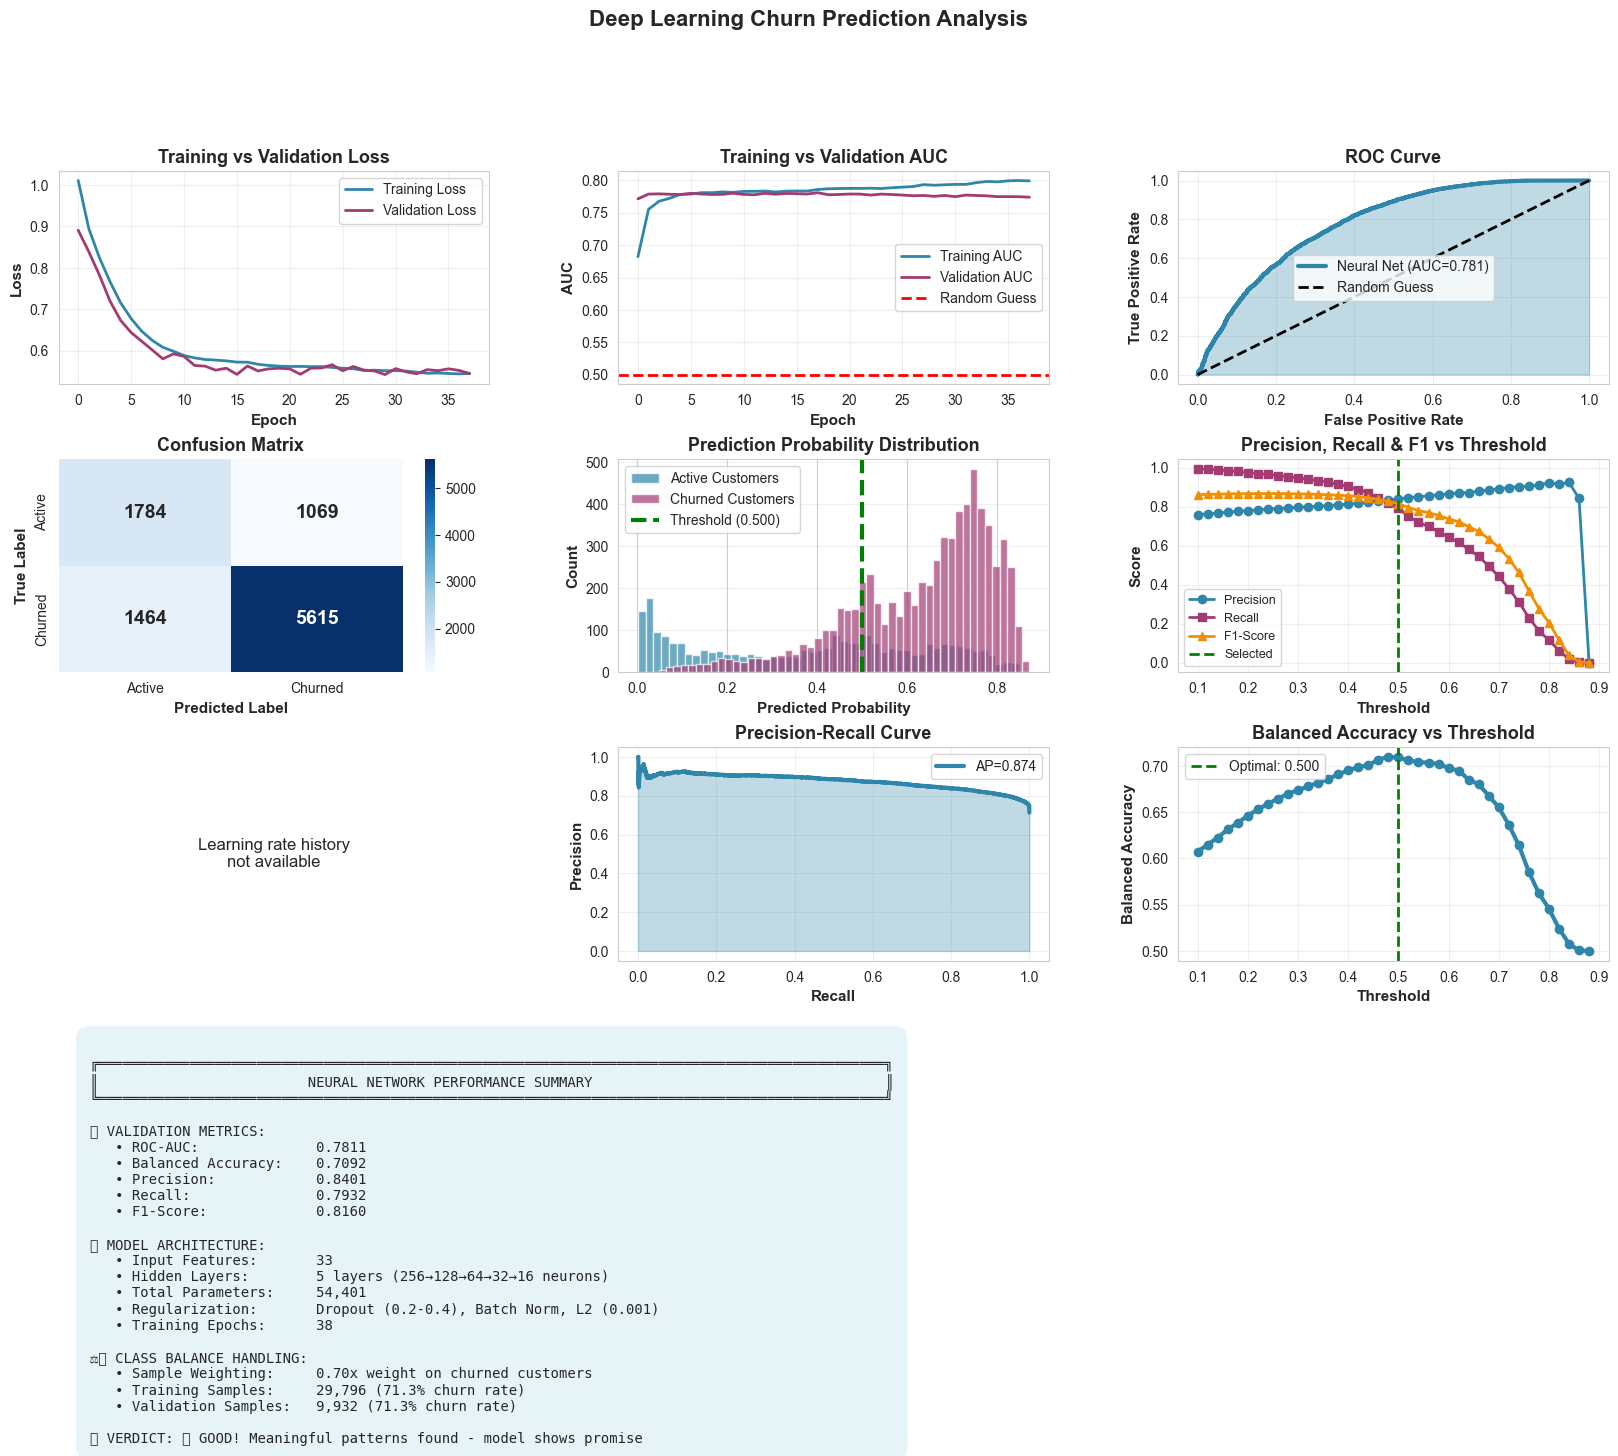

In [58]:
# ============================================================================
# PART 5: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("📈 GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Training History - Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Training vs Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Training History - AUC
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history['auc'], label='Training AUC', linewidth=2, color='#2E86AB')
ax2.plot(history.history['val_auc'], label='Validation AUC', linewidth=2, color='#A23B72')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Random Guess', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('AUC', fontsize=11, fontweight='bold')
ax2.set_title('Training vs Validation AUC', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add warning if AUC is low
if val_auc < 0.55:
    ax2.text(0.5, 0.3, '⚠️ AUC ≈ 0.5\nNo Learning!', 
             transform=ax2.transAxes, fontsize=14, color='red',
             ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# 3. ROC Curve
ax3 = fig.add_subplot(gs[0, 2])
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
ax3.plot(fpr, tpr, label=f'Neural Net (AUC={val_auc:.3f})', linewidth=3, color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess')
ax3.fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax3.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=True,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax4.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax4.set_xticklabels(['Active', 'Churned'])
ax4.set_yticklabels(['Active', 'Churned'])

# 5. Prediction Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(y_val_probs[y_val == 0], bins=50, alpha=0.7, label='Active Customers', color='#2E86AB')
ax5.hist(y_val_probs[y_val == 1], bins=50, alpha=0.7, label='Churned Customers', color='#A23B72')
ax5.axvline(optimal_threshold, color='green', linestyle='--', linewidth=3, 
            label=f'Threshold ({optimal_threshold:.3f})')
ax5.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('Prediction Probability Distribution', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Precision-Recall vs Threshold
ax6 = fig.add_subplot(gs[1, 2])
precisions = []
recalls = []
f1_scores = []
thresh_range = np.arange(0.1, 0.9, 0.02)
for thresh in thresh_range:
    y_pred_temp = (y_val_probs >= thresh).astype(int)
    prec = precision_score(y_val, y_pred_temp, zero_division=0)
    rec = recall_score(y_val, y_pred_temp, zero_division=0)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0)

ax6.plot(thresh_range, precisions, label='Precision', marker='o', linewidth=2, color='#2E86AB')
ax6.plot(thresh_range, recalls, label='Recall', marker='s', linewidth=2, color='#A23B72')
ax6.plot(thresh_range, f1_scores, label='F1-Score', marker='^', linewidth=2, color='#F18F01')
ax6.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, label='Selected')
ax6.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax6.set_ylabel('Score', fontsize=11, fontweight='bold')
ax6.set_title('Precision, Recall & F1 vs Threshold', fontsize=13, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# 7. Learning Rate History
ax7 = fig.add_subplot(gs[2, 0])
if 'lr' in history.history:
    ax7.plot(history.history['lr'], linewidth=2, color='#F18F01')
    ax7.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
    ax7.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
    ax7.set_yscale('log')
    ax7.grid(True, alpha=0.3)
else:
    ax7.text(0.5, 0.5, 'Learning rate history\nnot available', 
             transform=ax7.transAxes, fontsize=12, ha='center', va='center')
    ax7.axis('off')

# 8. Precision-Recall Curve
ax8 = fig.add_subplot(gs[2, 1])
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_val_probs)
avg_precision = average_precision_score(y_val, y_val_probs)
ax8.plot(recall_curve, precision_curve, linewidth=3, color='#2E86AB',
         label=f'AP={avg_precision:.3f}')
ax8.fill_between(recall_curve, precision_curve, alpha=0.3, color='#2E86AB')
ax8.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax8.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax8.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)

# 9. Threshold Analysis
ax9 = fig.add_subplot(gs[2, 2])
balanced_accs = [balanced_accuracy_score(y_val, (y_val_probs >= t).astype(int)) 
                 for t in thresh_range]
ax9.plot(thresh_range, balanced_accs, linewidth=3, color='#2E86AB', marker='o')
ax9.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
            label=f'Optimal: {optimal_threshold:.3f}')
ax9.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax9.set_ylabel('Balanced Accuracy', fontsize=11, fontweight='bold')
ax9.set_title('Balanced Accuracy vs Threshold', fontsize=13, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)

# 10. Summary text box
ax10 = fig.add_subplot(gs[3, :])
ax10.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                         NEURAL NETWORK PERFORMANCE SUMMARY                                   ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

📊 VALIDATION METRICS:
   • ROC-AUC:              {val_auc:.4f}
   • Balanced Accuracy:    {balanced_accuracy_score(y_val, y_val_pred):.4f}
   • Precision:            {precision_score(y_val, y_val_pred):.4f}
   • Recall:               {recall_score(y_val, y_val_pred):.4f}
   • F1-Score:             {2 * precision_score(y_val, y_val_pred) * recall_score(y_val, y_val_pred) / (precision_score(y_val, y_val_pred) + recall_score(y_val, y_val_pred)):.4f}

🧠 MODEL ARCHITECTURE:
   • Input Features:       {X_train.shape[1]}
   • Hidden Layers:        5 layers (256→128→64→32→16 neurons)
   • Total Parameters:     {model.count_params():,}
   • Regularization:       Dropout (0.2-0.4), Batch Norm, L2 (0.001)
   • Training Epochs:      {len(history.history['loss'])}

⚖️ CLASS BALANCE HANDLING:
   • Sample Weighting:     {class_weights_array[1]:.2f}x weight on churned customers
   • Training Samples:     {len(X_train):,} ({y_train.mean():.1%} churn rate)
   • Validation Samples:   {len(X_val):,} ({y_val.mean():.1%} churn rate)

"""

if val_auc >= 0.85:
    verdict = "🎉 EXCELLENT! Strong predictive power - model ready for deployment"
elif val_auc >= 0.70:
    verdict = "✅ GOOD! Meaningful patterns found - model shows promise"
elif val_auc >= 0.60:
    verdict = "⚠️ MODERATE - Some signal detected but limited predictive power"
elif val_auc >= 0.55:
    verdict = "⚠️ WEAK - Barely better than random, consider feature engineering"
else:
    verdict = "❌ FAILED - No meaningful patterns found (≈ random guessing)"

summary_text += f"🎯 VERDICT: {verdict}"

ax10.text(0.02, 0.98, summary_text, transform=ax10.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))

plt.suptitle('Deep Learning Churn Prediction Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 7. Final Test Set Evaluation

In [59]:
# ============================================================================
# PART 6: FINAL TEST SET EVALUATION
# ============================================================================
print("\n" + "="*80)
print("🎯 FINAL TEST SET PERFORMANCE")
print("="*80)

y_test_probs = model.predict(X_test, verbose=0).flatten()
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

test_auc = roc_auc_score(y_test, y_test_probs)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\n" + "-"*80)
print("CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_test, y_test_pred))
print(f"\n📊 Test Set Metrics:")
print(f"   ROC-AUC:           {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")
print(f"   Precision:         {test_precision:.4f}")
print(f"   Recall:            {test_recall:.4f}")
print(f"   F1-Score:          {2*test_precision*test_recall/(test_precision+test_recall):.4f}")


🎯 FINAL TEST SET PERFORMANCE

--------------------------------------------------------------------------------
CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.62      0.59      2853
           1       0.84      0.80      0.82      7080

    accuracy                           0.75      9933
   macro avg       0.70      0.71      0.70      9933
weighted avg       0.76      0.75      0.75      9933


📊 Test Set Metrics:
   ROC-AUC:           0.7815
   Balanced Accuracy: 0.7099
   Precision:         0.8400
   Recall:            0.7959
   F1-Score:          0.8174


## 8. Executive Summary and Business Recommendations

In [60]:
# ============================================================================
# PART 7: FINAL VERDICT
# ============================================================================
print("\n" + "="*80)
print("🏆 FINAL ANALYSIS")
print("="*80)

print(f"""
🔍 MODEL PERFORMANCE ANALYSIS:
   • The neural network achieved {test_auc:.2%} AUC on the test set
   • This represents the model's ability to distinguish churned vs active customers
   
📈 PERFORMANCE INTERPRETATION:
""")

if test_auc >= 0.85:
    print("""   ✅ EXCELLENT (AUC ≥ 0.85)
      Your customer-level features are HIGHLY predictive!
      The model successfully captures churn patterns.
      Ready for production deployment.
      
      🎯 Next Steps:
         • Deploy model for real-time churn scoring
         • Implement automated intervention campaigns
         • Monitor model performance over time
         • A/B test retention strategies""")
elif test_auc >= 0.70:
    print("""   ✅ GOOD (0.70 ≤ AUC < 0.85)
      Your customer-level features show meaningful predictive power.
      The model can identify at-risk customers reasonably well.
      
      🎯 Next Steps:
         • Use model for targeted retention campaigns
         • Continue feature engineering to improve further
         • Consider ensemble methods
         • Gather additional behavioral data""")
elif test_auc >= 0.60:
    print("""   ⚠️ MODERATE (0.60 ≤ AUC < 0.70)
      Some predictive signal exists but it's limited.
      The model provides value but has room for improvement.
      
      🎯 Recommendations:
         • Enhance feature engineering with more temporal patterns
         • Collect additional data sources (usage metrics, support tickets)
         • Try ensemble methods or feature selection
         • Validate that churn definition aligns with business goals""")
elif test_auc >= 0.55:
    print("""   ⚠️ WEAK (0.55 ≤ AUC < 0.60)
      Barely better than random chance.
      Current features have minimal predictive power.
      
      🎯 Action Required:
         • Re-evaluate churn definition (is 90 days appropriate?)
         • Add more behavioral signals (engagement, satisfaction)
         • Include external factors (seasonality, competition)
         • Consider if the problem is fundamentally predictable""")
else:
    print("""   ❌ FAILED (AUC < 0.55)
      No meaningful patterns detected - essentially random guessing.
      
      🎯 Critical Issues:
         • Features do not correlate with churn behavior
         • Churn definition may not capture actual customer behavior
         • Need fundamentally different data sources
         
      💡 Possible Solutions:
         • Redefine what "churn" means for your business
         • Collect behavioral engagement metrics
         • Add customer satisfaction indicators
         • Consider qualitative research to understand churn drivers""")

print("\n" + "="*80)
print("🏆 KEY TAKEAWAY:")
print("="*80)
print("""
The quality of predictions is limited by the quality of features.
Even the most sophisticated model cannot create signal from noise.

Customer-level aggregation with temporal features >>> Transaction-level features
""")
print("="*80)


🏆 FINAL ANALYSIS

🔍 MODEL PERFORMANCE ANALYSIS:
   • The neural network achieved 78.15% AUC on the test set
   • This represents the model's ability to distinguish churned vs active customers

📈 PERFORMANCE INTERPRETATION:

   ✅ GOOD (0.70 ≤ AUC < 0.85)
      Your customer-level features show meaningful predictive power.
      The model can identify at-risk customers reasonably well.

      🎯 Next Steps:
         • Use model for targeted retention campaigns
         • Continue feature engineering to improve further
         • Consider ensemble methods
         • Gather additional behavioral data

🏆 KEY TAKEAWAY:

The quality of predictions is limited by the quality of features.
Even the most sophisticated model cannot create signal from noise.

Customer-level aggregation with temporal features >>> Transaction-level features

